In [11]:
import cv2
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

0    2104
2     866
5     291
1     270
6     123
7      69
4       7
3       3
8       1
Name: Species, dtype: int64


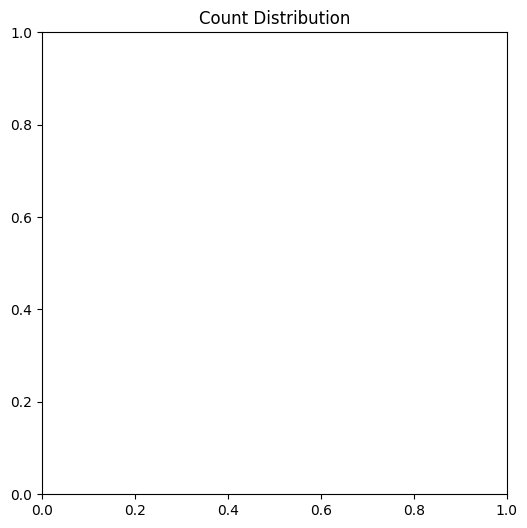

KeyboardInterrupt: 

In [14]:
def classes_csv_to_df(file_paths: list, delimiter=";") -> pd.DataFrame:
    df_all = pd.DataFrame()
    for file_path in file_paths:
        df_current = pd.read_csv(file_path, delimiter=delimiter)
        df_all = pd.concat([df_all, df_current])

    df_all = df_all.reset_index(drop=True)
    df_all = df_all.drop_duplicates()
    df_all.drop("Filename", axis=1, inplace=True)
    df_all = remove_unwanted_datapoints(df_all)
    
    #df_all.drop("Species", axis=1, inplace=True)
    return df_all

def categorical_classes(df: pd.DataFrame, column_name: str):
    # df passed as call by reference
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].astype('category')
    return df_copy

def numerical_classes(df: pd.DataFrame, column_name: str) -> tuple[pd.DataFrame, dict[int|str]]:
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].astype('category')
    class_mapping = dict(enumerate(df_copy[column_name].cat.categories))
    df_copy[column_name] = df_copy[column_name].cat.codes
    return df_copy, class_mapping

def encode_classes(df: pd.DataFrame, column_name: str):
    encoded_classes = pd.get_dummies(df[column_name])
    df = df.join(encoded_classes)
    return df

def remove_unwanted_datapoints(df: pd.DataFrame) -> pd.DataFrame:
    ids = set()
    duplicated_ids = set()
    #duplicates = list()
    for row in df.iterrows():
        id = row[1]["ID"]
        if id in ids:
            duplicated_ids.add(id)
            #duplicates.append(row)
        ids.add(id)

    # we drop than since they don't give us information in our trainingsprocess
    #print(len(df[df["Schwarzbild"] == 1]))
    #print(len(df[df["Fledermaus nicht bestimmbar"] == 1]))
    # since this are just 9 we just drop them
    # print(len(duplicates))
    return df[~((df['ID'].isin(duplicated_ids)) |
            (df['Species'].isin(['Fledermaus nicht bestimmbar', 'Schwarzbild'])))]\
            .reset_index(drop=True)

def class_mapping_to_csv(class_mapping_dict: dict) -> None: 
    with open('data/class_mapping.csv', 'w') as class_mapping_csv:  
        writer = csv.writer(class_mapping_csv)
        for key, value in class_mapping_dict.items():
            writer.writerow([key, value])

def plot_class_distribution(df: pd.DataFrame):
    plt.figure(figsize=(6,6))
    plt.savefig(df['Species'].value_counts())
    plt.title('Count Distribution')
    plt.show()

df = classes_csv_to_df(["../Auswertung_20220524.csv","../LMU_20180326_class.csv", "../LMU_20180505_classified.csv"])
df.replace("&Mausohr ", "Mausohr", inplace=True)
# RAM is cheaper than salary ;)
df_categorical = categorical_classes(df, "Species")
df_numerical, class_mapping = numerical_classes(df, "Species")
df_encoded = encode_classes(df, "Species")
class_mapping_to_csv(class_mapping)
plot_class_distribution(df_numerical)

def get_classes_from_id(id: int, df: pd.DataFrame) -> pd.Series:
    for row in df.iterrows():
        if id == row[1]["ID"]:
            return row[1].drop("ID")

def load_images_from_folder(folder_path: str, df_categorical: pd.DataFrame, df_numerical: pd.DataFrame, df_encoded: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    images_categorical = list()
    images_numerical = list()
    images_encoded = list()
    column_names = ["data", "Species"]
    column_names_encoded = ["data"] + list(df_encoded.columns)[1:]
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  
            img = cv2.imread(img_path)
            # some images are broken
            if img is not None:
                x, y, width, height = 54, 35, 334, 216
                # remove the transparent frame and unneeded scale
                img = img[y:y+height, x:x+width]
                class_categorical = get_classes_from_id(int(filename[:-4]), df_categorical)
                class_numerical = get_classes_from_id(int(filename[:-4]), df_numerical)
                class_encoded = get_classes_from_id(int(filename[:-4]), df_encoded)
                # need to check, if the class of the image is not null [aka. image would be one of the unwanted datapoints (e.g. class Schwarzbild)]
                if (class_categorical is not None) or (class_numerical is not None) or (class_encoded is not None):
                    images_categorical.append([img.flatten(), *class_categorical.values])
                    images_numerical.append([img.flatten(), *class_numerical.values])
                    images_encoded.append([img.flatten(), *class_encoded.values])

    #print(images_categorical)
    #print(np.array(images_categorical, dtype=object).shape)

    return pd.DataFrame(np.array(images_categorical, dtype=object), columns=column_names),\
        pd.DataFrame(np.array(images_numerical, dtype=object), columns=column_names),\
        pd.DataFrame(np.array(images_encoded, dtype=object), columns=column_names_encoded).drop("Species", axis=1)
            

images_categorical, images_df_numerical, images_df_encoded = load_images_from_folder("../Bat_Orientation_Calls/", df_categorical, df_numerical, df_encoded)
#print(images_categorical["data"].to_numpy().shape)
images_categorical.to_pickle("./data/images_df_categorical.pkl")
images_df_numerical.to_pickle("./data/images_df_numerical.pkl")
images_df_encoded.to_pickle("./data/images_df_encoded.pkl")

## 